In [1]:
import numpy as np
import pandas as pd
from StringIO import StringIO
import re
import os
import pickle
import random


class Cell:
    def __init__(self,v,p,fp,e):
        self.e = e
        self.p = p.copy()
        self.fp = fp.copy()
        self.v = v.copy()

def read_cfg(fname):
    with open(fname) as f:
            content = f.read()
    content = content.replace('\r','')
    energy = float(re.findall("-?[0-9]+.[0-9]*",re.findall("Energy\n[\t ]+-?[0-9]+.[0-9]*",content)[0])[0])
    tmp = content.split('SuperCell\n')[1].split(\
    '\n AtomData:  id type       cartes_x      cartes_y      cartes_z           fx          fy          fz'\
                                               )[0]
    matr = [float(x) for x in tmp.split()]
    v1 = np.array(matr[:3]); v2 = np.array(matr[3:6]); v3 = np.array(matr[6:])
    dat_table = content.split(\
    'AtomData:  id type       cartes_x      cartes_y      cartes_z           fx          fy          fz'\
                             )[1]
    dat_table = dat_table.split('Energy')[0]
    datx = dat_table.replace('\t', ' ').replace(' ',',')
    for space_num in range(10, 1, -1):
        datx = datx.replace(','*space_num,',')
    df = pd.read_csv(StringIO(datx[:-1]), header = None, sep = ',')
    df.columns = ['dump','ind','type','x','y','z','fx','fy','fz'] 
    df = df.apply(pd.to_numeric)
    
    return df,v1,v2,v3,energy
        
def read_all_data(data_dir):
    all_data = []
    sz  = len(os.listdir(data_dir))
    for j,i in enumerate(os.listdir(data_dir)):
        if(j % 500 == 0):
            print (j,sz)
        df,v1,v2,v3,energy = read_cfg(data_dir+'/'+i)        
        all_data.append(Cell(v=np.array([v1,v2,v3]),p=df.values[:,3:6],fp=df.values[:,6:9],e=energy))
    return all_data

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

    
#all_data = read_all_data('Ws/cfgs')
#save_obj(all_data,'all_data')
all_data = load_obj('all_data')

In [36]:
#from numba import jit
from scipy.spatial import cKDTree
from scipy.ndimage.interpolation import rotate
from numpy.random import rand
from scipy.linalg import expm,norm
import time


#@jit
def make_material(_max,v,p,p0):
    _01 = np.array([0,1],dtype=np.float32)
    box = _max*np.array(np.meshgrid(_01,_01,_01)).T.reshape(-1,3)
    box -= p0
    inv_v = np.linalg.inv(v.T)
    tmp = inv_v.dot(box.T)
    lo = (np.floor(tmp.min(1))-1).astype(np.int)
    hi = (np.ceil (tmp.max(1))+1).astype(np.int)
    tmp = hi - lo
    points = np.zeros((tmp[0]*tmp[1]*tmp[2]*len(p),3),dtype=np.float32)
    j = 0      
    beg = -np.abs(v).max()
    end = _max+np.abs(v).max()
    for i0 in range(lo[0],hi[0]):
        p1 = v[0]*i0+p0        
        for i1 in range(lo[1],hi[1]):
            p2 = v[1]*i1+p1
            for i2 in range(lo[2],hi[2]):
                p3 = v[2]*i2+p2
                for i4 in range(len(p)):
                    p4 = p3+p[i4]
                    if(all(p4 >= beg) and all(p4<=end)):
                        points[j][:] = p4[:]
                        j+=1
    return points[:j]

def make_grid(grid_num,grid_size):
    grid = np.zeros((grid_num,grid_num,grid_num,3),dtype=np.float32)
    x = np.linspace(0,grid_size,grid_num,False)
    grid[...,0] += x[:,None,None]
    grid[...,1] += x[None,:,None]
    grid[...,2] += x[None,None,:]
    return grid

def find_nearest(atoms,k,grid):
    tree = cKDTree(atoms)
    nearest_dist,nearest_ind = tree.query(grid,np.arange(1,k+1,dtype=np.int))
    return nearest_dist

def aug_basis(_v):
    v = _v.copy()
    axis = rand(3)
    theta = rand()*2*np.pi
    rot = expm(np.cross(np.eye(3), axis/norm(axis)*theta),3)#rotation matrix
    #v = rot.dot(v)
    return v

def batch_sample(data,grid,k,aug,grid_size):
    grid_num = grid.shape[0]
    batch_X = np.empty((len(data),grid_num,grid_num,grid_num,k),dtype=np.float32)
    batch_y = np.empty((len(data),1),dtype=np.float32)
    for i in range(len(data)):
        v = aug_basis(data[i].v) 
        atoms = make_material(grid_size,v,data[i].p,p0=rand(3)*grid_size)
        batch_X[i] = find_nearest(atoms,k,grid)
        batch_y[i] = grid_size**3/np.abs(np.linalg.det(v))*data[i].e
    batch_X = np.transpose(batch_X,(0,4,1,2,3))
    batch_y = (batch_y - energy_mean*grid_size**3)/(energy_var*grid_size**3)
    return np.exp(-batch_X/100.),batch_y
    

In [37]:
def draw_sample(x,cols=8,rows=8):
    w = x.shape[1]
    
    img = np.zeros((w*cols,w*rows),dtype=np.float32)
    for i in range(cols):
        for j in range(rows):
            img[i*w:i*w+w,j*w:j*w+w] = x[i*rows+j]
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.show()
    

In [38]:
from multiprocessing import Pool

def val_data_genertor(buffer_X,buffer_y,batch_size):
    prev = 0
    while(1):
        if(prev+batch_size > len(buffer_X)):
            break
        yield buffer_X[prev:prev+batch_size],buffer_y[prev:prev+batch_size]
        prev = prev+batch_size

def train_data_genertor(data,batch_size,grid_size,buffer_X,buffer_y):
    k = buffer_X.shape[1]
    grid_num = buffer_X.shape[2]
    grid = make_grid(grid_num,grid_size)
    indx = np.arange(0,len(buffer_X),dtype=np.int)
    cur_update = 0
    while(1):
        batch_indx = np.random.choice(indx,batch_size)
        if(np.random.rand() < 0.1):
            X,y = batch_sample(np.random.choice(data,1),grid,k,True,grid_size)
            buffer_X[[cur_update]] = X
            buffer_y[[cur_update]] = y
            cur_update = (cur_update+1) % len(buffer_X)
            
        yield buffer_X[batch_indx],buffer_y[batch_indx]
        

        

In [39]:
grid_size = 24
grid_num = 64
k = 3
batch_size = 8
energy = np.array([ i.e/np.linalg.det(i.v) for i in all_data])
energy_mean = energy.mean()
energy_var = np.sqrt(((energy-energy_mean)**2).mean())

random.shuffle(all_data)
train_data,val_data = all_data[50:],all_data[:50]

train_buffer_X,train_buffer_y = batch_sample(np.random.choice(train_data,50),
                                             grid=make_grid(grid_num,grid_size),
                                             k=k,
                                             aug=True,
                                             grid_size=grid_size)

val_buffer_X,val_buffer_y = batch_sample(val_data,
                                         grid = make_grid(grid_num,grid_size),
                                         k=k,
                                         aug=False,
                                         grid_size=grid_size)

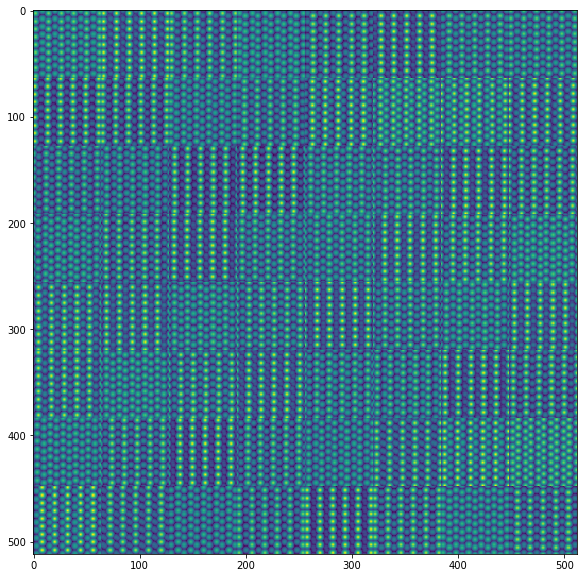

[[-0.183]]


In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(3)
for j,i in enumerate(train_data_genertor(all_data,1,grid_size,train_buffer_X,train_buffer_y)):
    draw_sample(i[0][0,0,:,:,:])
    print (i[1])
    break

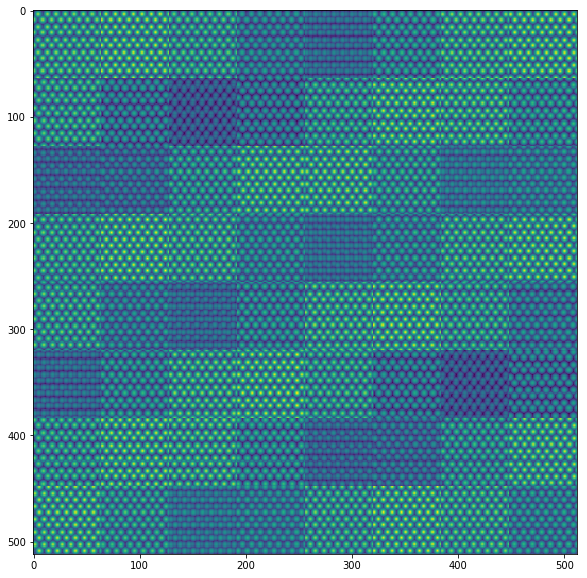

[[ 0.086]]


In [43]:
np.set_printoptions(3)
for j,i in enumerate(val_data_genertor(val_buffer_X,val_buffer_y,1)):
    draw_sample(i[0][0,0,:,:,:])
    print (i[1])
    break

In [16]:
import theano

In [17]:
import theano.tensor as T
import lasagne
from lasagne.layers.dnn import Conv3DDNNLayer, MaxPool3DDNNLayer
from lasagne.layers import *

In [18]:
from lasagne.nonlinearities import *

In [ ]:
def build(input_shape,t_input):
    def make_conv_unit(l,nf,name):
        res = Conv3DDNNLayer(l,nf,(3,3,3),pad='same',name = 'conv_'+name,nonlinearity=None)
        res = BatchNormLayer(res,name = 'bn_'+name)
        res = NonlinearityLayer(res,name = 'relu_'+name,nonlinearity=rectify)
        return res
    
    def make_dense(l,n,name,nonl = rectify):
        res = BatchNormLayer(l,name = 'bn_'+name)
        res = DenseLayer(res,n,name = 'fc_'+name,nonlinearity=nonl)
        return res
    
    all_l = []
    all_l.append(InputLayer(input_shape,input_var = t_input))
    all_l.append(make_conv_unit(all_l[-1],16,'1'))
    all_l.append(make_conv_unit(MaxPool3DDNNLayer(all_l[-1],(2,2,2)),32,'2'))
    all_l.append(make_conv_unit(MaxPool3DDNNLayer(all_l[-1],(2,2,2)),64,'3'))
    all_l.append(make_conv_unit(MaxPool3DDNNLayer(all_l[-1],(2,2,2)),128,'4'))
    all_l.append(make_conv_unit(MaxPool3DDNNLayer(all_l[-1],(2,2,2)),256,'5'))
    res = ReshapeLayer(all_l[-1],(input_shape[0],256,-1))
    res = GlobalPoolLayer(res,T.mean)    
    res = make_dense(res,512,'1')
    res = make_dense(res,512,'2')
    res = make_dense(res,1,'output',None)
    return res


input_shape = (batch_size,k,grid_num,grid_num,grid_num)
t_input = T.tensor5('data')
t_label = T.matrix('label')
net = build(input_shape,t_input)
    

In [45]:
pred = get_output(net)
params = get_all_params(net, trainable=True)
loss = lasagne.objectives.squared_error(pred,t_label).mean()
G_lr = theano.shared(np.array(0.001, dtype=theano.config.floatX))
updates = lasagne.updates.adam(loss,params,G_lr)
print ('start')
train_fn = theano.function([t_input,t_label],[loss], allow_input_downcast=True, updates=updates)
print ('train_fn compiled')
test_fn = theano.function([t_input,t_label],[loss], allow_input_downcast=True)
print ('test_fn compiled')



start
train_fn compiled
test_fn compiled


In [27]:
G_lr.set_value(np.float(0.001))

In [47]:
from tqdm import tqdm
    
num_epoch = 100
batches_per_epoch = 300
for i in range(num_epoch):
    train_num_batch = 0.
    train_loss = 0.
    for i,batch in enumerate(train_data_genertor(train_data,batch_size,grid_size,train_buffer_X,train_buffer_y)):
        if(i >= batches_per_epoch):
            break
        train_loss += train_fn(batch[0],batch[1])[0]
        train_num_batch += 1.
        if(i % 10 == 0):
            print '\r %i %f'%(i,train_loss/train_num_batch),
        
    val_loss = 0.
    val_num_batch = 0.
    for i,batch in enumerate(val_data_genertor(val_buffer_X,val_buffer_y,batch_size)):
        val_loss += test_fn(batch[0],batch[1])[0]
        val_num_batch += 1.

    print ('\repoch %i train_loss=%f val_loss=%f'%(i,train_loss/train_num_batch,val_loss/val_num_batch))
    